In [71]:
# Imports needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [72]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [73]:
faq_df = pd.read_csv("faq_dataset.csv") # --> if this throws an error please put the dataset in the same folder as the notebook 
# or just change this to the file location path on your computer :)

In [74]:
faq_df

,question,answer,category,language
0,How can I reset my password?,Go to settings → account → reset password. You...,Account,en
1,What payment methods do you support?,We support credit cards (Visa/Mastercard/Amex)...,Billing,en
2,Why can't I log into my account?,Make sure your email is verified and that you ...,Account,en
3,How do I contact customer support?,You can contact us via live chat (9 AM - 6 PM ...,Support,en
4,Can I change my subscription plan?,"Yes, you can upgrade or downgrade anytime from...",Billing,en
5,Do you support Macedonian language?,"Yes, our platform supports multiple languages ...",Product,en
6,How do refunds work?,Refunds are processed within 5-7 business days...,Billing,en
7,Is my data secure?,"Yes, we use industry-standard 256-bit SSL encr...",Security,en
8,Do you have a mobile app?,Yes! Our mobile app is available for iOS and A...,Product,en
9,What happens if I exceed my usage limits?,You'll receive a notification and can either u...,Billing,en


In [75]:
# This is just a simple visualization to see the language and category distribution
print(f"Loaded {len(faq_df)} FAQs")
print(f"\nLanguage distribution:")
print(faq_df['language'].value_counts())
print(f"\nCategory distribution:")
print(faq_df['category'].value_counts())

Loaded 20 FAQs

Language distribution:
language
en    15
mk     5
Name: count, dtype: int64

Category distribution:
category
Account       6
Billing       6
Support       3
Product       3
Security      1
Onboarding    1
Name: count, dtype: int64


In [76]:
### 1. Load model
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

In [77]:
### 2.Creating embeddings for all FAQ questions
questions = faq_df['question'].tolist()

faq_embeddings = model.encode(
    questions,
    convert_to_numpy=True,
    normalize_embeddings=True,
    show_progress_bar=True
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [78]:
# Save embeddings for faster loading next time (it's just cache)
np.save('faq_embeddings.npy', faq_embeddings)

In [79]:
# Here we just make a scoring method just to make it look more understandable
# Convert similarity score to confidence level
def get_confidence_level(score):
    if score >= 0.7:
        return "High"
    elif score >= 0.4:
        return "Medium"
    else:
        return "Low"

In [80]:
### 3. Retrieval Function 
# Here we retrive the top most relevant FAQs for our query
# As arguments we pass the User's query, the number of results to retrun, and the minimum similarity score/threshold
# We return the list of dictionaries with the question,answer,score,confidence
def retrieve_faq(query, top_k=3, threshold=0.0):
    # Encode query
    query_emb = model.encode([query], normalize_embeddings=True)
    
    # Calculate similarities
    similarities = cosine_similarity(query_emb, faq_embeddings)[0]
    
    # Get top-k indices
    top_idx = np.argsort(similarities)[::-1][:top_k]
    
    # Filter by threshold
    top_idx = [idx for idx in top_idx if similarities[idx] >= threshold]
    
    # Build results
    results = []
    for idx in top_idx:
        score = float(similarities[idx])
        results.append({
            "question": faq_df.iloc[idx]['question'],
            "answer": faq_df.iloc[idx]['answer'],
            "category": faq_df.iloc[idx]['category'],
            "language": faq_df.iloc[idx]['language'],
            "score": score,
            "confidence": get_confidence_level(score)
        })
    
    return results

In [81]:
### 4. Test Retrieval
# Test with different queries
# -------------------------
# MODE 1: Show normal Top-3 retrieval results
# -------------------------
test_queries = [
    "I forgot my password",
    "What are the payment options?",
    "Cannot log into account"
]

for query in test_queries:
    print(f"\n{'-'*70}")
    print(f"Query: '{query}'")
    print('-'*70)
    
    results = retrieve_faq(query, top_k=3)
    
    for i, r in enumerate(results, 1):
        confidence_symbol = ":)" if r['confidence'] == "High" else ":|" if r['confidence'] == "Medium" else ":("
        print(f"\n{confidence_symbol} Result {i} - {r['confidence']} Confidence ({r['score']:.3f})")
        print(f"   Q: {r['question']}")
        print(f"   A: {r['answer'][:80]}...")
        print(f"   [Category: {r['category']} | Language: {r['language']}]")



----------------------------------------------------------------------
Query: 'I forgot my password'
----------------------------------------------------------------------

:) Result 1 - High Confidence (0.819)
   Q: Како да ја ресетирам мојата лозинка?
   A: Одете на поставки → сметка → ресетирај лозинка. Ќе добиете е-пошта со инструкции...
   [Category: Account | Language: mk]

:) Result 2 - High Confidence (0.798)
   Q: How can I reset my password?
   A: Go to settings → account → reset password. You will receive an email with instru...
   [Category: Account | Language: en]

:| Result 3 - Medium Confidence (0.590)
   Q: Why can't I log into my account?
   A: Make sure your email is verified and that you are using the correct login creden...
   [Category: Account | Language: en]

----------------------------------------------------------------------
Query: 'What are the payment options?'
----------------------------------------------------------------------

:) Result 1 - High Confi

In [82]:
# -------------------------
# MODE 2: Production-style filtering with confidence threshold
# This MODE is just for filtering weak answers, we just adjusted the threshold to be 0.820
# Returns only answers we trust (>= 0.820 similarity)
# -------------------------

for query in test_queries:
    print(f"\n{'-'*70}")
    print(f"Query: '{query}'")
    print('-'*70)
    
    results = retrieve_faq(query, top_k=3,threshold=0.820)
    
    if not results:
        print("No confident match found. Escalating to support or asking user for clarification.")
        continue

    for i, r in enumerate(results, 1):
        confidence_symbol = ":)" if r['confidence'] == "High" else ":|" if r['confidence'] == "Medium" else ":("
        print(f"\n{confidence_symbol} Result {i} - {r['confidence']} Confidence ({r['score']:.3f})")
        print(f"   Q: {r['question']}")
        print(f"   A: {r['answer'][:80]}...")
        print(f"   [Category: {r['category']} | Language: {r['language']}]")


----------------------------------------------------------------------
Query: 'I forgot my password'
----------------------------------------------------------------------
No confident match found. Escalating to support or asking user for clarification.

----------------------------------------------------------------------
Query: 'What are the payment options?'
----------------------------------------------------------------------

:) Result 1 - High Confidence (0.825)
   Q: What payment methods do you support?
   A: We support credit cards (Visa/Mastercard/Amex), PayPal, and bank transfers for e...
   [Category: Billing | Language: en]

----------------------------------------------------------------------
Query: 'Cannot log into account'
----------------------------------------------------------------------

:) Result 1 - High Confidence (0.875)
   Q: Why can't I log into my account?
   A: Make sure your email is verified and that you are using the correct login creden...
   [Categ

In [83]:
### 5. Evaluation Metrics
# Evaluating our system using ML metrics
# - **Hits@1**: Is the top result correct
# - **Hits@3**: Is the correct answer in top 3
# - **MRR**: Mean Reciprocal Rank

# We evaluate retrival system on test cases
# As arguments we pass a list of dicts with query and expected
# This returns the dictionary with evaluation metrics

def evaluate_system(test_cases):
    hits_1 = 0
    hits_3 = 0
    mrr_scores = []
    
    for test in test_cases:
        results = retrieve_faq(test['query'], top_k=3)
        expected_question = faq_df.iloc[test['expected_idx']]['question']
        
        # Check Hits@1
        if len(results) > 0 and results[0]['question'] == expected_question:
            hits_1 += 1
            mrr_scores.append(1.0)
        else:
            # Find rank of correct answer
            for rank, r in enumerate(results, 1):
                if r['question'] == expected_question:
                    mrr_scores.append(1.0 / rank)
                    break
            else:
                mrr_scores.append(0.0)
        
        # Check Hits@3
        if any(r['question'] == expected_question for r in results):
            hits_3 += 1
    
    n = len(test_cases)
    return {
        'hits@1': hits_1 / n,
        'hits@3': hits_3 / n,
        'mrr': np.mean(mrr_scores),
        'total_queries': n
    }

In [84]:
# Define test cases
test_cases = [
    {'query': 'I forgot my password', 'expected_idx': 0},
    {'query': 'Which payment methods are supported?', 'expected_idx': 1},
    {'query': 'Cannot access my account', 'expected_idx': 2},
    {'query': 'reach customer support', 'expected_idx': 3},
    {'query': 'change plan', 'expected_idx': 4},
    {'query': 'get refund', 'expected_idx': 6},
]

In [85]:
metrics = evaluate_system(test_cases)

print("EVALUATION RESULTS\n")
print(f"Hits@1 (top result correct):     {metrics['hits@1']:.1%} ({int(metrics['hits@1']*metrics['total_queries'])}/{metrics['total_queries']})")
print(f"Hits@3 (answer in top 3):        {metrics['hits@3']:.1%} ({int(metrics['hits@3']*metrics['total_queries'])}/{metrics['total_queries']})")
print(f"MRR (Mean Reciprocal Rank):      {metrics['mrr']:.3f}")

EVALUATION RESULTS

Hits@1 (top result correct):     66.7% (4/6)
Hits@3 (answer in top 3):        100.0% (6/6)
MRR (Mean Reciprocal Rank):      0.833


In [86]:
### 6. Multilingual Support Test 
# 
# The Bonus Feature - Test cross-lingual retrieval (EN ↔ MK)

print("MULTILINGUAL CAPABILITY TEST")

# Test 1: English query
query_en = "How do I reset my password?"
print(f"\n English Query: '{query_en}'")
results_en = retrieve_faq(query_en, top_k=3)
for r in results_en:
    flag = "en" if r['language'] == 'en' else "🇲🇰"
    print(f"  {flag} [{r['language']}] {r['question'][:50]}... (score: {r['score']:.3f})")

# Test 2: Macedonian query (transliterated)
query_mk = "Kako da resetiram lozinka?"
print(f"\n Macedonian Query: '{query_mk}'")
results_mk = retrieve_faq(query_mk, top_k=3)
for r in results_mk:
    flag = "en" if r['language'] == 'en' else "🇲🇰"
    print(f"  {flag} [{r['language']}] {r['question'][:50]}... (score: {r['score']:.3f})")

# Test 3: Macedonian Cyrillic
query_mk_cyr = "Не можам да се најавам"
print(f"\n Macedonian Cyrillic Query: '{query_mk_cyr}'")
results_mk_cyr = retrieve_faq(query_mk_cyr, top_k=3)
for r in results_mk_cyr:
    flag = "en" if r['language'] == 'en' else "🇲🇰"
    print(f"  {flag} [{r['language']}] {r['question'][:50]}... (score: {r['score']:.3f})")

MULTILINGUAL CAPABILITY TEST

 English Query: 'How do I reset my password?'
  en [en] How can I reset my password?... (score: 0.997)
  🇲🇰 [mk] Како да ја ресетирам мојата лозинка?... (score: 0.907)
  en [en] Why can't I log into my account?... (score: 0.566)

 Macedonian Query: 'Kako da resetiram lozinka?'
  en [en] How can I reset my password?... (score: 0.956)
  🇲🇰 [mk] Како да ја ресетирам мојата лозинка?... (score: 0.880)
  en [en] Why can't I log into my account?... (score: 0.565)

 Macedonian Cyrillic Query: 'Не можам да се најавам'
  🇲🇰 [mk] Зошто не можам да се најавам на мојата сметка?... (score: 0.632)
  en [en] Why can't I log into my account?... (score: 0.519)
  en [en] How can I reset my password?... (score: 0.384)


In [87]:
### 7. Confidence Score Analysis
# Test with relevant and irrelevant queries
relevant_queries = [
    "reset password",
    "payment methods", 
    "login problem",
    "contact support"
]

irrelevant_queries = [
    "weather forecast",
    "cooking recipes",
    "movie recommendations",
    "sports scores"
]

In [88]:
# Get top scores
relevant_scores = []
for q in relevant_queries:
    res = retrieve_faq(q, top_k=1)
    if res:
        relevant_scores.append(res[0]['score'])

irrelevant_scores = []
for q in irrelevant_queries:
    res = retrieve_faq(q, top_k=1)
    if res:
        irrelevant_scores.append(res[0]['score'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_30812\2377592577.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([relevant_scores, irrelevant_scores], labels=['Relevant', 'Irrelevant'])


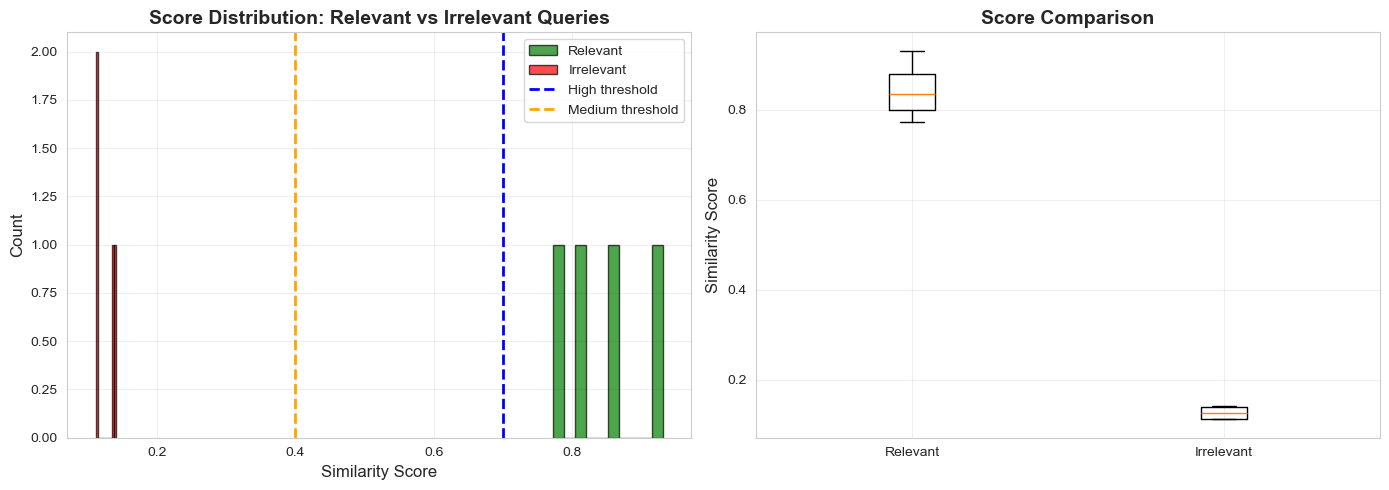

In [89]:
# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(relevant_scores, bins=10, alpha=0.7, label='Relevant', color='green', edgecolor='black')
ax1.hist(irrelevant_scores, bins=10, alpha=0.7, label='Irrelevant', color='red', edgecolor='black')
ax1.axvline(0.7, color='blue', linestyle='--', linewidth=2, label='High threshold')
ax1.axvline(0.4, color='orange', linestyle='--', linewidth=2, label='Medium threshold')
ax1.set_xlabel('Similarity Score', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Score Distribution: Relevant vs Irrelevant Queries', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot
ax2.boxplot([relevant_scores, irrelevant_scores], labels=['Relevant', 'Irrelevant'])
ax2.set_ylabel('Similarity Score', fontsize=12)
ax2.set_title('Score Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# If you haven't aready cought on, I like to make pretty visuals :D

In [90]:
# This here is just a clear separation between relevant and irrelevant queries
print(f"Relevant queries:   Mean = {np.mean(relevant_scores):.3f}, Std = {np.std(relevant_scores):.3f}")
print(f"Irrelevant queries: Mean = {np.mean(irrelevant_scores):.3f}, Std = {np.std(irrelevant_scores):.3f}")
print(f"Separation:         {np.mean(relevant_scores) - np.mean(irrelevant_scores):.3f}")

Relevant queries:   Mean = 0.843, Std = 0.060
Irrelevant queries: Mean = 0.126, Std = 0.014
Separation:         0.717


In [91]:
### 8. Performance Benchmarking 

import time

# Benchmark query latency
n_runs = 100
query = "reset password"

latencies = []

for _ in range(n_runs):
    start = time.time()
    retrieve_faq(query, top_k=3)
    latencies.append((time.time() - start) * 1000)  # Convert to ms

# Calculate statistics
print("PERFORMANCE METRICS\n")
print(f"Mean latency:    {np.mean(latencies):.2f}ms")
print(f"Median latency:  {np.median(latencies):.2f}ms")
print(f"P95 latency:     {np.percentile(latencies, 95):.2f}ms")
print(f"P99 latency:     {np.percentile(latencies, 99):.2f}ms")
print(f"Throughput:      {1000/np.mean(latencies):.1f} queries/second")

PERFORMANCE METRICS

Mean latency:    12.37ms
Median latency:  12.12ms
P95 latency:     14.24ms
P99 latency:     16.30ms
Throughput:      80.9 queries/second


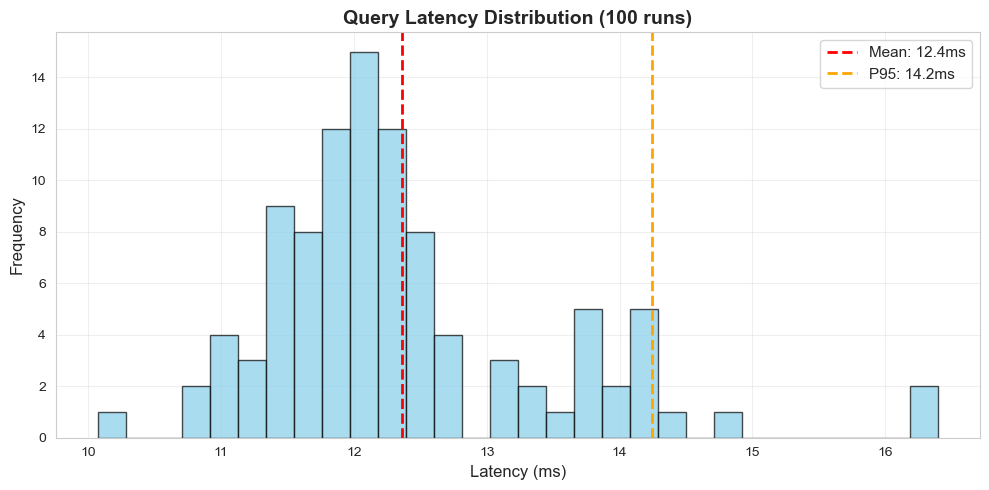

In [92]:
# Visualize latency distribution
plt.figure(figsize=(10, 5))
plt.hist(latencies, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(np.mean(latencies), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(latencies):.1f}ms')
plt.axvline(np.percentile(latencies, 95), color='orange', linestyle='--', linewidth=2, 
            label=f'P95: {np.percentile(latencies, 95):.1f}ms')
plt.xlabel('Latency (ms)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Query Latency Distribution (100 runs)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [93]:
### 9. Interactive Demo 

def demo_search(query):
    print(f"\n{'-'*70}")
    print(f"*** Query: '{query}'")
    print('-'*70)
    
    results = retrieve_faq(query, top_k=3)
    
    if not results:
        print("No results found.")
        return
    
    for i, r in enumerate(results, 1):
        confidence_symbol = ":)" if r['confidence'] == "High" else ":|" if r['confidence'] == "Medium" else ":("
        
        print(f"\n{confidence_symbol} Result {i}: {r['confidence']} Confidence ({r['score']:.3f})")
        print(f"Q: {r['question']}")
        print(f"A: {r['answer']}")
        print(f"[Category: {r['category']} | Language: {r['language']}]")


In [94]:
# Test with various queries
demo_queries = [
    "I forgot my password",
    "payment options available",
    "Не можам да се најавам"
]

In [95]:
for q in demo_queries:
    demo_search(q)


----------------------------------------------------------------------
*** Query: 'I forgot my password'
----------------------------------------------------------------------

:) Result 1: High Confidence (0.819)
Q: Како да ја ресетирам мојата лозинка?
A: Одете на поставки → сметка → ресетирај лозинка. Ќе добиете е-пошта со инструкции.
[Category: Account | Language: mk]

:) Result 2: High Confidence (0.798)
Q: How can I reset my password?
A: Go to settings → account → reset password. You will receive an email with instructions.
[Category: Account | Language: en]

:| Result 3: Medium Confidence (0.590)
Q: Why can't I log into my account?
A: Make sure your email is verified and that you are using the correct login credentials. If issues persist, try resetting your password.
[Category: Account | Language: en]

----------------------------------------------------------------------
*** Query: 'payment options available'
---------------------------------------------------------------------